# Biodiversity in National Parks
This project forms part of the Codecademy 'Data Science Foundations' course, and uses a synthetic dataset from Codecademy.<br>
I will explore data from the National Parks Service, and investigate whether there are any patterns or themes to the types of species that become endangered.

## 1. Importing libraries and data files

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

observations = pd.read_csv("observations.csv")
species_info = pd.read_csv("species_info.csv")

## 2. Inspecting the data

In [2]:
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [3]:
observations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


In [4]:
#checking for exact duplicates
len(observations) - len(observations.drop_duplicates())

15

In [5]:
# All the listings for Vicia benghalensis - just exploring
vic_beng = observations[observations['scientific_name'] == "Vicia benghalensis"]
vic_beng

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
10447,Vicia benghalensis,Yosemite National Park,148
12455,Vicia benghalensis,Yellowstone National Park,247
15518,Vicia benghalensis,Bryce National Park,104


In [6]:
# All the listings for Prunus subcordata - just exploring
prun_sub = observations[observations['scientific_name'] == "Prunus subcordata"]
prun_sub

,scientific_name,park_name,observations
2,Prunus subcordata,Yosemite National Park,138
4987,Prunus subcordata,Yellowstone National Park,217
8622,Prunus subcordata,Bryce National Park,91
16282,Prunus subcordata,Great Smoky Mountains National Park,72


The **observations file** contains a vast number of records, 23,296 and it appears to be "clean":
* There is no missing data.
* In general every species has exactly one listing for each park, and none of the observations are zero - all species were observed multiple times in each of the four parks.
* There are 15 rows which are true duplicates - all columns repeated.  However, this could be genuine - the same number of observations could have been made on different dates at the same park, so these aren't necessarily errors.
* The spelling and punctuation is very consistant.
* The column names are lower case without spaces, which makes them easy to use.
* The data types are valid. If we want to perform any string functions on the names, we'll need to store them as strings rather than objects, but this is unlikely.
* It looks like the Park names may have been picked against a list, so we may want to identify all the unique values to check that we don't have duplicates relating to data entry errors

In [7]:
list(observations.park_name.unique())

['Great Smoky Mountains National Park',
 'Yosemite National Park',
 'Bryce National Park',
 'Yellowstone National Park']

This is all good.  It looks like a suspiciously clean dataset used for teaching purposes!

In [8]:
species_info.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [9]:
species_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


Comments on the **Species File**:
* It looks like the two dataframes can be linked via the scientific_name field.
* The conservation_status column has a lot of missing data.
* The common_names column has multiple comma-separated entries.

Checking once again that the categories field has a relevant list of unique entries without duplicates caused by typos:

In [10]:
list(species_info.category.unique())

['Mammal',
 'Bird',
 'Reptile',
 'Amphibian',
 'Fish',
 'Vascular Plant',
 'Nonvascular Plant']

In [11]:
nunique_observations = observations.scientific_name.nunique()
print(f"there are {nunique_observations} unique species in the observations dataframe")

nunique_species = species_info.scientific_name.nunique()
print(f"there are {nunique_species} unique species in the species_info dataframe")

there are 5541 unique species in the observations dataframe
there are 5541 unique species in the species_info dataframe


Following my observation that the two dataframes can be linked via the scientific_name field:</br>
Intuitively you'd expect a one to many relationship where a species in the species_info data frame can have anything from 0 to many related entries in the observations dataframe, and that each possible species is listed once and once only in the species_info table.</br>
However, it's a little counter-intuitive that the species_info table has 5541 unique species, but 5824 entries, so perhaps there are some duplicates. This needs further investigation.

## 3. Cleaning and Pre-Processing the data

### What to do about the conservation status column having a lot of missing data?

As a rule of thumb, fields with > 60% of data missing could just be removed

In [12]:
prop_missing = species_info.conservation_status.isna().sum() / species_info.shape[0]
print(f"{prop_missing:.2%}")

96.72%


This is such a high proportion it would normally make sense to drop the column, but have they left it missing to denote something?  Check unique values.

In [13]:
species_info.conservation_status.value_counts()

conservation_status
Species of Concern    161
Endangered             16
Threatened             10
In Recovery             4
Name: count, dtype: int64

It looks like missing values may mean "No Concern", given that this is a value which surely ought to be present, but isn't.  Given the nature of the project, dropping the column doesn't make sense. It's not entirely a safe assumption that all missing values mean "No Concern" but none-the-less I have chosen to replace missing values in this column with "No Concern" in order to proceed with the analysis.

In [14]:
species_info['conservation_status'] = species_info['conservation_status'].fillna("No Concern")
species_info.conservation_status.value_counts()


conservation_status
No Concern            5633
Species of Concern     161
Endangered              16
Threatened              10
In Recovery              4
Name: count, dtype: int64

### What to do about duplicates of scientific names in the species info dataframe?

If there are rows which are identical across all columns, there is no harm in just dropping them with drop_duplicates

In [15]:
len(species_info) - len(species_info.drop_duplicates())

0

There weren't any simple ones.  But still, the species_info table has 5824 rows for 5541 unique species.  It must be that in some cases there are multiple rows for some species, but only the scientific names are duplicated, the rows aren't otherwise identical.<br>
Will run duplicated, with keep = False argument, and sorted by scientific_name, to bunch together all relevant duplicates and have a look at them.

In [16]:
duplicated_species = species_info[species_info.duplicated('scientific_name', keep=False)].sort_values(by=['scientific_name'])
len(duplicated_species)

557

In [17]:
print(duplicated_species.head(8))

            category      scientific_name  \
5553  Vascular Plant  Agrostis capillaris   
2132  Vascular Plant  Agrostis capillaris   
2134  Vascular Plant    Agrostis gigantea   
5554  Vascular Plant    Agrostis gigantea   
4178  Vascular Plant   Agrostis mertensii   
2136  Vascular Plant   Agrostis mertensii   
2138  Vascular Plant      Agrostis scabra   
5556  Vascular Plant      Agrostis scabra   

                                  common_names conservation_status  
5553         Colonial Bent, Colonial Bentgrass          No Concern  
2132                         Rhode Island Bent          No Concern  
2134                                    Redtop          No Concern  
5554       Black Bent, Redtop, Water Bentgrass          No Concern  
4178      Arctic Bentgrass, Northern Bentgrass          No Concern  
2136                         Northern Agrostis          No Concern  
2138          Rough Bentgrass, Rough Hairgrass          No Concern  
5556  Rough Bent, Rough Bentgrass, Tickleg

This confirms that there are duplicate entries for the same species, with different information in the common_names fields (and potentially the category or conservation_status fields, but that wasn't shown up in the first 8 rows, so first things first).

We'll concatenate the common_names together, so as not to lose any information (as opposed to just deleting second or third rows outright).

Not sure this is actually helpful for the project at hand, but it's good experience!

In [18]:
species_info = species_info.groupby(['category', 'scientific_name', 'conservation_status']).agg({'common_names': ', '.join}).reset_index()
len(species_info)

5543

We still have two duplicate rows:  5543 rows for 5541 scientifi names.  Lets look at these two individually.

In [19]:
duplicated_species = species_info[species_info.duplicated('scientific_name', keep=False)].sort_values(by=['scientific_name'])
print(duplicated_species)

    category      scientific_name conservation_status  \
705   Mammal          Canis lupus          Endangered   
706   Mammal          Canis lupus         In Recovery   
664     Fish  Oncorhynchus mykiss          No Concern   
665     Fish  Oncorhynchus mykiss          Threatened   

                   common_names  
705  Gray Wolf, Gray Wolf, Wolf  
706             Gray Wolf, Wolf  
664               Rainbow Trout  
665               Rainbow Trout  


These two duplicates weren't dealt with in the previous step because they have different conservation statuses.  I'll assume that #706 is more accurate than #705 (since those statuses feel sequential) and that 665 is more correct that 664 (because 'No Concern' was automatically inserted for missing data). 
 I'll just manually remove #705 and #664.

In [20]:
species_info = species_info.drop([705, 664])
print(species_info.shape[0])
print(species_info.scientific_name.nunique())

5541
5541


Are the 5541 species in the Species Info dataframe the same as the 5541 in the Observations dataframe?

In [21]:
species_in_species_info = list(species_info.scientific_name.unique())
species_in_observations = list(observations.scientific_name.unique())

if species_in_species_info.sort() == species_in_observations.sort():
    print("The lists are identical")
else:
    print("The lists are not identical")

The lists are identical


Good result: the Species Info dataframe now acts as a comprehensive list of the species in the Observations dataframe with one listing for each species.

### Giving the conservation status categories a logical order

In [22]:
species_info.conservation_status.unique()

array(['No Concern', 'Threatened', 'Species of Concern', 'Endangered',
       'In Recovery'], dtype=object)

In [23]:
species_info.conservation_status = pd.Categorical(species_info.conservation_status, 
    ['No Concern', 'In Recovery', 'Species of Concern', 'Threatened', 'Endangered'], ordered = True)

In [24]:
species_info.conservation_status.unique()

['No Concern', 'Threatened', 'Species of Concern', 'Endangered', 'In Recovery']
Categories (5, object): ['No Concern' < 'In Recovery' < 'Species of Concern' < 'Threatened' < 'Endangered']

### Aggregating the observations counts from one dataframe into the other dataframe

First groupby to sum the observations counts, storing as a dataframe

In [25]:
obs_count = observations.groupby('scientific_name').observations.sum().to_frame().reset_index()
print(obs_count)

                          scientific_name  observations
0                           Abies bifolia           532
1                          Abies concolor           630
2                           Abies fraseri           518
3                    Abietinella abietina           592
4                       Abronia ammophila           523
...                                   ...           ...
5536      Zonotrichia leucophrys gambelii           560
5537      Zonotrichia leucophrys oriantha           558
5538                  Zonotrichia querula           616
5539                 Zygodon viridissimus           600
5540  Zygodon viridissimus var. rupestris           651

[5541 rows x 2 columns]


Now merge into a new combined dataframe

In [26]:
species_with_counts = species_info.merge(obs_count)
print(species_with_counts.head())

    category                    scientific_name conservation_status  \
0  Amphibian          Acris crepitans crepitans          No Concern   
1  Amphibian                Ambystoma maculatum          No Concern   
2  Amphibian  Ambystoma mavortium melanostictum          No Concern   
3  Amphibian                   Ambystoma opacum          No Concern   
4  Amphibian               Ambystoma talpoideum          No Concern   

                common_names  observations  
0      Northern Cricket Frog           531  
1         Spotted Salamander           539  
2  Blotched Tiger Salamander           607  
3         Marbled Salamander           661  
4            Mole Salamander           546  


In [27]:
# Just checking a single species to be sure the groupby worked as expected
obs_ambymac = observations[observations['scientific_name'] == "Ambystoma maculatum"]
print(obs_ambymac)

           scientific_name                            park_name  observations
1295   Ambystoma maculatum               Yosemite National Park           163
3293   Ambystoma maculatum            Yellowstone National Park           233
16111  Ambystoma maculatum                  Bryce National Park            92
17054  Ambystoma maculatum  Great Smoky Mountains National Park            51


### Adding the species category into the observations dataframe

In [28]:
obs_with_cats = observations.merge(species_info[['scientific_name','category']])
print(obs_with_cats.head())

            scientific_name                            park_name  \
0        Vicia benghalensis  Great Smoky Mountains National Park   
1            Neovison vison  Great Smoky Mountains National Park   
2         Prunus subcordata               Yosemite National Park   
3      Abutilon theophrasti                  Bryce National Park   
4  Githopsis specularioides  Great Smoky Mountains National Park   

   observations        category  
0            68  Vascular Plant  
1            77          Mammal  
2           138  Vascular Plant  
3            84  Vascular Plant  
4            85  Vascular Plant  


## 4. Exploratory Data Analysis

### Which categories have the highest average number of observations per species?

First as table using groupby, then as chart using sns barplot

In [29]:
counts_by_category = round(species_with_counts.groupby('category').observations.mean().sort_values(ascending = False),1).to_frame().reset_index()
print(counts_by_category)

            category  observations
0             Mammal         663.0
1               Bird         600.1
2     Vascular Plant         599.5
3            Reptile         572.8
4  Nonvascular Plant         572.5
5               Fish         566.5
6          Amphibian         556.6


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Amphibian'),
  Text(1, 0, 'Bird'),
  Text(2, 0, 'Fish'),
  Text(3, 0, 'Mammal'),
  Text(4, 0, 'Nonvascular Plant'),
  Text(5, 0, 'Reptile'),
  Text(6, 0, 'Vascular Plant')])

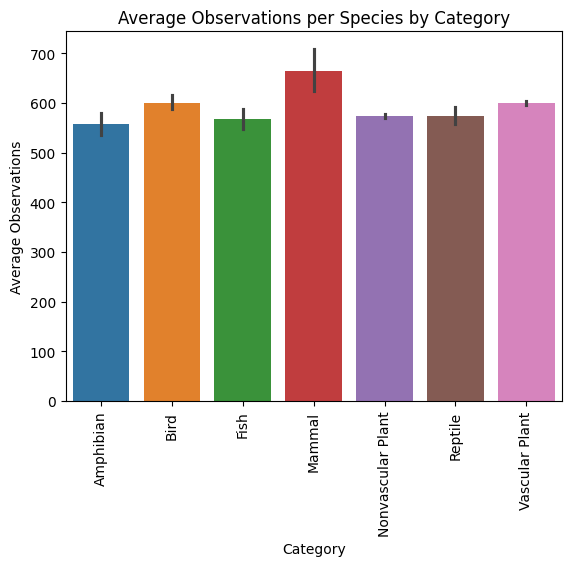

In [30]:
sns.barplot(x = 'category', y ='observations', data = species_with_counts, hue = 'category')
plt.xlabel("Category")
plt.ylabel("Average Observations")
plt.title("Average Observations per Species by Category")
plt.xticks(rotation="vertical")

The mammals tended to have the highest number of observations per species, perhaps because they're relatively big and easy to spot.

### Which are the most frequently and least frequently observed species?

In [31]:
top_5 = species_with_counts.sort_values(by=['observations'], ascending = False)[:5]
top_5

,category,scientific_name,conservation_status,common_names,observations
507,Bird,Streptopelia decaocto,No Concern,"Eurasian Collared-Dove, Eurasian Collared Dove...",1785
3188,Vascular Plant,Holcus lanatus,No Concern,"Common Velvet Grass, Velvetgrass, Common Velve...",1780
706,Mammal,Castor canadensis,No Concern,"American Beaver, Beaver, American Beaver, Beaver",1725
3260,Vascular Plant,Hypochaeris radicata,No Concern,"Cat's Ear, Spotted Cat's-Ear, Spotted Cats-Ear...",1720
807,Mammal,Puma concolor,No Concern,"Panther (Mountain Lion), Cougar, Mountain Lion...",1711


In [32]:
bottom_5 = species_with_counts.sort_values(by=['observations'])[:5]
bottom_5

,category,scientific_name,conservation_status,common_names,observations
284,Bird,Grus americana,Endangered,Whooping Crane,131
705,Mammal,Canis rufus,Endangered,Red Wolf,137
537,Bird,Vermivora bachmanii,Endangered,"Bachman's Warbler, Bachman's Wood Warbler",141
657,Fish,Noturus baileyi,Endangered,Smoky Madtom,143
72,Amphibian,Rana sierrae,Endangered,Sierra Nevada Yellow-Legged Frog,144


Interstingly, the most and least frequently seen species were both birds.<br>
Unsurprisingly, the most frequently seen species all had the conservation status "No Concern", and the least frequently seen species were listed as "Endangered".

### Are all of the 'Endangered' species seen less than all of the 'No Concern' species, or is there some overlap?

Side by side boxplots will help with this.

([0, 1, 2, 3, 4],
 [Text(0, 0, 'No Concern'),
  Text(1, 0, 'In Recovery'),
  Text(2, 0, 'Species of Concern'),
  Text(3, 0, 'Threatened'),
  Text(4, 0, 'Endangered')])

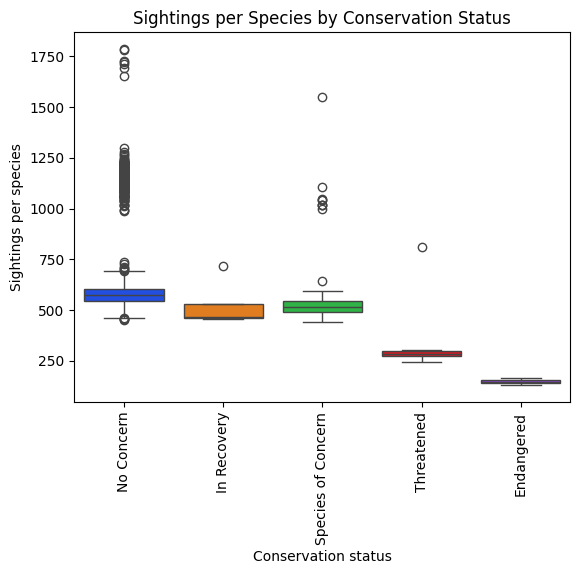

In [33]:
sns.boxplot(data = species_with_counts, x = "conservation_status", y = "observations", hue = "conservation_status", palette = "bright")
plt.title("Sightings per Species by Conservation Status")
plt.xlabel("Conservation status")
plt.ylabel("Sightings per species")
plt.xticks(rotation="vertical")

The conservation statuses clearly relate to the average number of observations per species.<br>
There is no overlap between "no concern" and "endangered" - there are no outliers where an endangered species was observed more often than a species of no concern.

### Which categories are most likely to be endangered?

In [34]:
categories_by_conservation = round(pd.crosstab(species_info.conservation_status, species_info.category, normalize='columns') * 100, 1)
categories_by_conservation

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
No Concern,91.1,84.6,91.2,83.0,98.5,93.6,98.9
In Recovery,0.0,0.6,0.0,0.6,0.0,0.0,0.0
Species of Concern,5.1,13.9,3.2,12.5,1.5,6.4,1.0
Threatened,2.5,0.0,3.2,1.1,0.0,0.0,0.0
Endangered,1.3,0.8,2.4,2.8,0.0,0.0,0.0


The above table shows the % of species in a category which have each of the conversations statuses.<br>
The mammals seem to be the most threatened - only 83% of mammal species are of "No Concern", which is lower than any of the other species categories, and 2.8% of mammal species are "Endangered" which is higher than any of the other species categories.<br>
The vascular plants seem to be the least threatened - 98.9% are of "No Concern".<br>
It appears that mammals are more likely to be endangered, so let's examine the potential correlation between mammals / not mammals, and endangered / not endangered using Chi Squared.  That is - is that 2.8% on the final row significantly higher than the other figures on that row?  The null hypothesis being that mammals are no more or less likely to be endangered than non-mammals.<br>
Start by looking up the figures for the contingency table.

In [35]:
categories_by_conservation_figs = pd.crosstab(species_info.conservation_status, species_info.category, margins=True, margins_name='Total')
categories_by_conservation_figs

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant,Total
conservation_status,,,,,,,,
No Concern,72,413,114,146,328,73,4216,5362
In Recovery,0,3,0,1,0,0,0,4
Species of Concern,4,68,4,22,5,5,43,151
Threatened,2,0,4,2,0,0,2,10
Endangered,1,4,3,5,0,0,1,14
Total,79,488,125,176,333,78,4262,5541


Next I create and print the contingency table, perform the Chi Squared hypothesis test, and print out the p value.

In [36]:
mammal_not_endangered = 176 - 5
mammal_endangered = 5
not_mammel_not_endangered = 5541 - 14
not_mammel_endangered = 14

mammal_endangered_contingency_table = [[mammal_endangered, mammal_not_endangered],[not_mammel_endangered, not_mammel_not_endangered]]

for figure in mammal_endangered_contingency_table:
    print (*figure)
    
chi2, pval, dof, expected = chi2_contingency(mammal_endangered_contingency_table)
print(f"The p-value to 4dp is {pval:.4f}")

5 171
14 5527
The p-value to 4dp is 0.0000


This p value is well under 0.05, so it appears that there is a significant correlation between whether a species is classed as "endangered" and whether or not it is a mammal.  Mammals are more likely to be endangered.

### Are there particular parks which are best for observing particular categories of species?

First make a pivot table of parks vs categories, with observation counts.

([0, 1, 2, 3],
 [Text(0, 0, 'Bryce National Park'),
  Text(1, 0, 'Great Smoky Mountains National Park'),
  Text(2, 0, 'Yellowstone National Park'),
  Text(3, 0, 'Yosemite National Park')])

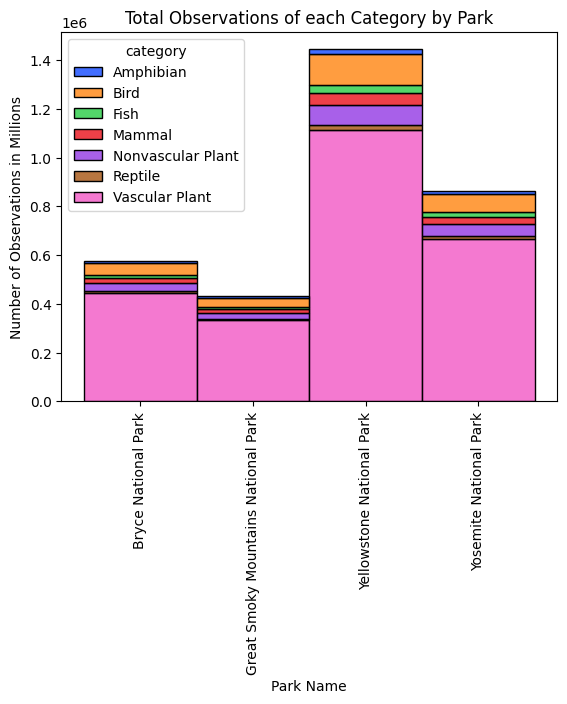

In [37]:
park_cat_totals = obs_with_cats.groupby(['park_name','category']).observations.sum().to_frame().reset_index()

sns.histplot(park_cat_totals, x='park_name', hue='category', weights = 'observations', multiple='stack', palette = 'bright')
plt.xlabel("Park Name")
plt.ylabel("Number of Observations in Millions")
plt.title("Total Observations of each Category by Park")
plt.xticks(rotation="vertical")

Stacked bar charts aren't popular, but I think this one is useful
* Yellowstone has the most observations, so whatever you want to see head there.
* Wherever you go, a lot of the species you see are likely to be vascular plants, because there are a lot of different species of vascular plants.
* The proportions of each category appear to be roughly similar everywhere, so I won't investigate that any further, but will turn to individual species.

### Are there particular parks which are best for observing particular individual species?

In [38]:
species_park_totals = obs_with_cats.groupby(['park_name','scientific_name']).observations.sum().to_frame().reset_index()
species_park_pivot = species_park_totals.pivot_table(columns = 'park_name', index = 'scientific_name', values = 'observations')
species_park_pivot.head()

park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
scientific_name,,,,
Abies bifolia,109.0,72.0,215.0,136.0
Abies concolor,83.0,101.0,241.0,205.0
Abies fraseri,109.0,81.0,218.0,110.0
Abietinella abietina,101.0,65.0,243.0,183.0
Abronia ammophila,92.0,72.0,222.0,137.0


This is the first five rows of a huge table, with counts for every species at every park.  Next, I add columns for % at each park.

In [39]:
species_park_pivot['Total'] = species_park_pivot['Bryce National Park'] + species_park_pivot['Great Smoky Mountains National Park']+ species_park_pivot['Yellowstone National Park'] + species_park_pivot['Yosemite National Park']
park_names = (observations.park_name.unique())

for park in park_names:
    species_park_pivot["prop_" + park] = species_park_pivot.apply(lambda row: float(round(row[park] / row['Total'] * 100, 1)), axis = 1)

species_park_pivot.columns= ['bryce',
 'smoky',
 'yellowstone',
 'yosemite',
 'total',
 'prop_smoky',
 'prop_yosemite',
 'prop_bryce',
 'prop_yellowstone']

species_park_pivot.head()

,bryce,smoky,yellowstone,yosemite,total,prop_smoky,prop_yosemite,prop_bryce,prop_yellowstone
scientific_name,,,,,,,,,
Abies bifolia,109.0,72.0,215.0,136.0,532.0,13.5,25.6,20.5,40.4
Abies concolor,83.0,101.0,241.0,205.0,630.0,16.0,32.5,13.2,38.3
Abies fraseri,109.0,81.0,218.0,110.0,518.0,15.6,21.2,21.0,42.1
Abietinella abietina,101.0,65.0,243.0,183.0,592.0,11.0,30.9,17.1,41.0
Abronia ammophila,92.0,72.0,222.0,137.0,523.0,13.8,26.2,17.6,42.4


The next cell loops through each park to see whether the proportion of observations of any species is particularly high or low compared to their own averages (comparing to their own averages because we've seen that Yellowstone is so dominant and will always come out top).  It only prints out the anomalies.

In [40]:
parks = list(species_park_pivot.columns[:4])

for park in parks:
    print("**Anomalies at " + park + "**")
    high_threshold = species_park_pivot["prop_" + park].mean() * 1.75
    low_threshold = species_park_pivot["prop_" + park].mean() * 0.2
    high_skewed = species_park_pivot[species_park_pivot["prop_" + park] > high_threshold]
    low_skewed = species_park_pivot[species_park_pivot["prop_" + park] < low_threshold]
    if len(high_skewed) == 0:
        print("No species over-represented")
    else:
        print(f"Species over-represented, given that this park usually accounts for {species_park_pivot["prop_" + park].mean():.1f}% of observations:")
        for index, row in high_skewed.iterrows():
            print(f"\t {index} {row[park]:.0f} sightings ({row["prop_" + park]:.1f}%)")
    if len(low_skewed) == 0:
        print("No species under-represented")
    else:
        print(f"Species under-represented, given that this park usually accounts for {species_park_pivot["prop_" + park].mean():.1f}% of observations:")
        for index, row in low_skewed.iterrows():
            print(f"\t {index} {row[park]:.0f} sightings ({row["prop_" + park]:.1f}%)")
    print('\n')


**Anomalies at bryce**
No species over-represented
Species under-represented, given that this park usually accounts for 17.3% of observations:
	 Corydalis aurea 9 sightings (1.8%)


**Anomalies at smoky**
Species over-represented, given that this park usually accounts for 13.0% of observations:
	 Acer glabrum 123 sightings (23.5%)
	 Scirpus expansus 125 sightings (23.0%)
	 Sonchus asper ssp. asper 147 sightings (24.4%)
Species under-represented, given that this park usually accounts for 13.0% of observations:
	 Collomia tinctoria 10 sightings (1.8%)
	 Sambucus mexicana 12 sightings (2.3%)
	 Strix occidentalis 11 sightings (2.2%)


**Anomalies at yellowstone**
No species over-represented
No species under-represented


**Anomalies at yosemite**
No species over-represented
No species under-represented




This shows us any particularly big anomalies e.g. don't go to Bryce National Park if it's Corydalis Aurea that you're really wanting to see etc.

## Conclusions

* This was a good exercise especially in terms of handling missing values and duplicates, and in combining datasets.<br>
* The mammals were shown to be significantly the most threatened category, and the vascular plants the least threatened.<br>
* The Whooping Crane was the least frequently observed species, and is classed as "Endangered".<br>
* Yellowstone generally has the highest sightings of the four parks, which may be due to various factors such as more scientists collecting data there, so we cannot necessarily conclude that it is the most successful wildlife habitat.<br>